앞서 ['학습과정과 데이터셋 이야기'](https://tykimos.github.io/2017/03/25/Dataset_and_Fit_Talk/)에서 과적합이라는 것을 살펴보았고, 이를 방지하기 위해 조기 종료하는 시점에 대해서 알아보았습니다. 이번에는 케라스에서 제공하는 기능을 이용하여 학습 중에 어떻게 조기 종료를 시킬 수 있는 지 알아보겠습니다.

---

### 과적합되는 모델 살펴보기

먼저 과적합되는 모델을 만들고 어떻게 학습이 되었는 지 살펴보겠습니다. 아래 코드에서 사용된 데이터수, 배치사이즈, 뉴런 수 등은 과적합 현상을 재현하기 하기 위해 설정된 것으로 실제 최적화된 수치는 아닙니다.

Train on 700 samples, validate on 300 samples
Epoch 1/3000
700/700 [==============================] - 0s - loss: 2.3067 - acc: 0.1171 - val_loss: 2.2751 - val_acc: 0.0933
Epoch 2/3000
700/700 [==============================] - 0s - loss: 2.2731 - acc: 0.1257 - val_loss: 2.2508 - val_acc: 0.1267
Epoch 3/3000
700/700 [==============================] - 0s - loss: 2.2479 - acc: 0.1343 - val_loss: 2.2230 - val_acc: 0.1267
Epoch 4/3000
700/700 [==============================] - 0s - loss: 2.2220 - acc: 0.1471 - val_loss: 2.1984 - val_acc: 0.1233
Epoch 5/3000
700/700 [==============================] - 0s - loss: 2.1957 - acc: 0.1400 - val_loss: 2.1724 - val_acc: 0.1233
Epoch 6/3000
700/700 [==============================] - 0s - loss: 2.1685 - acc: 0.1457 - val_loss: 2.1513 - val_acc: 0.1133
Epoch 7/3000
700/700 [==============================] - 0s - loss: 2.1424 - acc: 0.1757 - val_loss: 2.1276 - val_acc: 0.1533
Epoch 8/3000
700/700 [==============================] - 0s - loss: 2.1174 - acc

Using Theano backend.


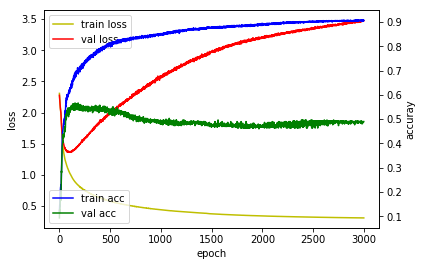

 7680/10000 [======================>.......] - ETA: 0s
loss : 3.73021918621
accuray : 0.4499


In [1]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

np.random.seed(3)

# 1. 데이터셋 준비하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 훈련셋과 검증셋 분리
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

# 데이터셋 전처리
x_train = x_train.reshape(50000, 784).astype('float32') / 255.0
x_val = x_val.reshape(10000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

# 훈련셋과 검증셋 고르기
train_rand_idxs = np.random.choice(50000, 700)
val_rand_idxs = np.random.choice(10000, 300)

x_train = x_train[train_rand_idxs]
y_train = y_train[train_rand_idxs]
x_val = x_val[val_rand_idxs]
y_val = y_val[val_rand_idxs]

# 라벨데이터 원핫인코딩 (one-hot encoding) 처리
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=2, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=3000, batch_size=10, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)

print('')
print('loss : ' + str(loss_and_metrics[0]))
print('accuray : ' + str(loss_and_metrics[1]))

![img](http://tykimos.github.io/warehouse/2017-7-9-Early_Stopping_1.png)

val_loss를 보면 에포크 횟수가 많아질 수록 감소하다가 150 에포크 근처에서 다시 증가됨을 알 수 있습니다. 이때 과적합이 발생한 것 입니다.

---

### 조기 종료 시키기

학습 조기 종료를 위해서는 ‘EarlyStopping()’이라는 함수를 사용하며 더 이상 개선의 여지가 없을 때 학습을 종료시키는 콜백함수입니다.  콜백함수라는 것 어떤 함수를 수행 시 그 함수에서 내가 지정한 함수를 호출하는 것을 말하며, 여기서는 fit() 함수에서 EarlyStopping() 콜백함수가 학습 과정 중에 매번 호출됩니다. 먼저 fit() 함수에서 EarlyStopping() 콜백함수를 지정하는 방법은 다음과 같습니다.

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
hist = model.fit(x_train, y_train, epochs=3000, batch_size=10, validation_data=(x_val, y_val), callbacks=[early_stopping])

에포크를 3000으로 지정했더라도 학습 과정에서 EarlyStopping 콜백함수를 호출하여 해당 조건이 되면 학습을 조기 종료시킵니다. EarlyStopping 콜백함수에서 설정할 수 있는 인자는 다음과 같습니다.

	keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

* monitor : 관찰하고자 하는 항목입니다. ‘val_loss’나 ‘val_acc’가 주로 사용됩니다. 
* min_delta : 개선되고 있다고 판단하기 위한 최소 변화량을 나타냅니다. 만약 변화량이 min_delta보다 적은 경우에는 개선이 없다고 판단합니다.
* patience : 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄 것인 가를 지정합니다. 만약 10이라고 지정하면 개선이 없는 에포크가 10번째 지속될 경우 학습일 종료합니다. 
* verbose : 얼마나 자세하게 정보를 표시할 것인가를 지정합니다. (0, 1, 2)
* mode : 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 지정합니다. 예를 들어 관찰 항목이 ‘val_loss’인 경우에는 감소되는 것이 멈출 때 종료되어야 하므로, ‘min’으로 설정됩니다.
	- auto : 관찰하는 이름에 따라 자동으로 지정합니다. 
	- min : 관찰하고 있는 항목이 감소되는 것을 멈출 때 종료합니다.
	- max : 관찰하고 있는 항목이 증가되는 것을 멈출 때 종료합니다.
    
조기 종료 콜백함수를 적용한 코드는 다음과 같습니다.

Train on 700 samples, validate on 300 samples
Epoch 1/3000
700/700 [==============================] - 0s - loss: 2.3067 - acc: 0.1171 - val_loss: 2.2751 - val_acc: 0.0933
Epoch 2/3000
700/700 [==============================] - 0s - loss: 2.2731 - acc: 0.1257 - val_loss: 2.2508 - val_acc: 0.1267
Epoch 3/3000
700/700 [==============================] - 0s - loss: 2.2479 - acc: 0.1343 - val_loss: 2.2230 - val_acc: 0.1267
Epoch 4/3000
700/700 [==============================] - 0s - loss: 2.2220 - acc: 0.1471 - val_loss: 2.1984 - val_acc: 0.1233
Epoch 5/3000
700/700 [==============================] - 0s - loss: 2.1957 - acc: 0.1400 - val_loss: 2.1724 - val_acc: 0.1233
Epoch 6/3000
700/700 [==============================] - 0s - loss: 2.1685 - acc: 0.1457 - val_loss: 2.1513 - val_acc: 0.1133
Epoch 7/3000
700/700 [==============================] - 0s - loss: 2.1424 - acc: 0.1757 - val_loss: 2.1276 - val_acc: 0.1533
Epoch 8/3000
700/700 [==============================] - 0s - loss: 2.1174 - acc

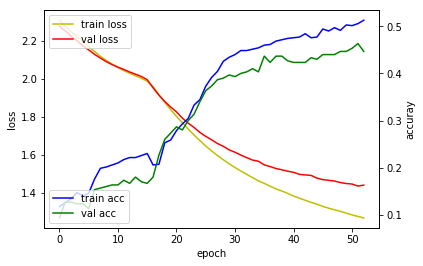

 6688/10000 [===================>..........] - ETA: 0s
loss : 1.439551894
accuray : 0.4443


In [2]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

np.random.seed(3)

# 1. 데이터셋 준비하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 훈련셋과 검증셋 분리
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

# 데이터셋 전처리
x_train = x_train.reshape(50000, 784).astype('float32') / 255.0
x_val = x_val.reshape(10000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

# 훈련셋과 검증셋 고르기
train_rand_idxs = np.random.choice(50000, 700)
val_rand_idxs = np.random.choice(10000, 300)

x_train = x_train[train_rand_idxs]
y_train = y_train[train_rand_idxs]
x_val = x_val[val_rand_idxs]
y_val = y_val[val_rand_idxs]

# 라벨데이터 원핫인코딩 (one-hot encoding) 처리
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=2, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
hist = model.fit(x_train, y_train, epochs=3000, batch_size=10, validation_data=(x_val, y_val), callbacks=[early_stopping])

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)

print('')
print('loss : ' + str(loss_and_metrics[0]))
print('accuray : ' + str(loss_and_metrics[1]))

![img](http://tykimos.github.io/warehouse/2017-7-9-Early_Stopping_2.png)

val_loss 값이 감소되다가 증가되자마자 학습이 종료되었습니다. 하지만 이 모델은 좀 더 학습이 될 수 있는 모델임을 이미 알고 있습니다. val_loss 특성 상 증가/감소를 반복하므로 val_loss가 증가되는 시점에 바로 종료하지말고 지속적으로 증가되는 시점에서 종료해보겠습니다. 이를 위해 EarlyStopping 콜백함수에서 patience 인자를 사용합니다.

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20)
hist = model.fit(x_train, y_train, epochs=3000, batch_size=10, validation_data=(x_val, y_val), callbacks=[early_stopping])

즉 증가가 되었더라도 20 에포크 동안은 기다려보도록 지정했습니다. 이를 적용한 코드는 다음과 같습니다.

Train on 700 samples, validate on 300 samples
Epoch 1/3000
700/700 [==============================] - 0s - loss: 2.3067 - acc: 0.1171 - val_loss: 2.2751 - val_acc: 0.0933
Epoch 2/3000
700/700 [==============================] - 0s - loss: 2.2731 - acc: 0.1257 - val_loss: 2.2508 - val_acc: 0.1267
Epoch 3/3000
700/700 [==============================] - 0s - loss: 2.2479 - acc: 0.1343 - val_loss: 2.2230 - val_acc: 0.1267
Epoch 4/3000
700/700 [==============================] - 0s - loss: 2.2220 - acc: 0.1471 - val_loss: 2.1984 - val_acc: 0.1233
Epoch 5/3000
700/700 [==============================] - 0s - loss: 2.1957 - acc: 0.1400 - val_loss: 2.1724 - val_acc: 0.1233
Epoch 6/3000
700/700 [==============================] - 0s - loss: 2.1685 - acc: 0.1457 - val_loss: 2.1513 - val_acc: 0.1133
Epoch 7/3000
700/700 [==============================] - 0s - loss: 2.1424 - acc: 0.1757 - val_loss: 2.1276 - val_acc: 0.1533
Epoch 8/3000
700/700 [==============================] - 0s - loss: 2.1174 - acc

Using Theano backend.


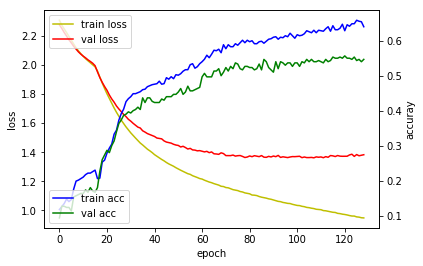

   32/10000 [..............................] - ETA: 0s
loss : 1.34829078026
accuray : 0.5344


In [1]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

np.random.seed(3)

# 1. 데이터셋 준비하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 훈련셋과 검증셋 분리
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

# 데이터셋 전처리
x_train = x_train.reshape(50000, 784).astype('float32') / 255.0
x_val = x_val.reshape(10000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

# 훈련셋과 검증셋 고르기
train_rand_idxs = np.random.choice(50000, 700)
val_rand_idxs = np.random.choice(10000, 300)

x_train = x_train[train_rand_idxs]
y_train = y_train[train_rand_idxs]
x_val = x_val[val_rand_idxs]
y_val = y_val[val_rand_idxs]

# 라벨데이터 원핫인코딩 (one-hot encoding) 처리
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=2, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20)
hist = model.fit(x_train, y_train, epochs=3000, batch_size=10, validation_data=(x_val, y_val), callbacks=[early_stopping])

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)

print('')
print('loss : ' + str(loss_and_metrics[0]))
print('accuray : ' + str(loss_and_metrics[1]))

![img](http://tykimos.github.io/warehouse/2017-7-9-Early_Stopping_3.png)

과적합이 발생되거나 성급하게 학습을 조기종료한 모델보다 적절히 조기종료한 모델의 정확도가 높게 나왔습니다. 아래는 세가지 모델을 비교한 표입니다.

|구분|과적합 발생|성급한 조기종료|적절한 조기종료|
|:-:|:-:|:-:|:-:|
|손실값|3.73|1.43|1.34|
|정확도|0.44|0.44|0.53|

---

### Q & A

Q1) 조기종료 시점을 정하기가 쉽지 않습니다. 과적합이 되는 지 확인하기 위해서 처음에 충분한 에포크 횟수로 학습한 뒤 과적합 시점을 확인 한 후 다시 학습을 시켜야 하는 지요?

A1) 케라스에서 제공하는 ModelCheckpoint()라는 콜백함수를 이용하면 매 에포크마다 학습된 가중치를 파일로 저장할 수 있습니다. 과적합이 일어난 시점에서의 에포크를 확인한 후 해당하는 가중치를 실제 모델에 적용하면 됩니다. 보통은 학습을 모두 마쳐야만 모델을 테스트 할 수 있지만 이 콜백함수를 사용하면 에포크마다 가중치가 생성되기 때문에, 이 가중치를 불러와서 모델의 정확도를 중간 점검할 수 있습니다. 학습시간이 길 경우 요긴하게 사용할 수 있습니다.

---

### 요약

본 절에서는 과적합되는 모델을 만들어보고, 조기종료 시키는 방법에 대해서 알아보았습니다. 케라스에서 제공하는 EarlyStopping 콜백함수를 조기종료에 사용해보았고, 설정 인자를 살펴보았습니다.

![img](http://tykimos.github.io/warehouse/2017-7-9-Early_Stopping_4.png)

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/lecture/)
* 이전 : [학습과정 표시하기 (텐서보드 포함)](https://tykimos.github.io/2017/07/09/Training_Monitoring/)    
* 다음 : [학습 모델 저장하기/불러오기](https://tykimos.github.io/2017/06/10/Model_Save_Load/)